In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

text = open('../texts/Стругацие - Стажеры.txt', 'rt', encoding='utf8').read()
len(text)

388559

### 1. Pre-trained word2vec models


In [2]:
!pip install fasttext
import fasttext.util
import numpy as np

In [3]:
fasttext.util.download_model('ru', if_exists='ignore')
ft = fasttext.load_model('cc.ru.300.bin')

In [4]:
fasttext.util.reduce_model(ft, 50)
print(ft.get_dimension())
ft.save_model('cc.ru.50.bin')

50


#### Преобразование слов в вектора и обратно

In [5]:
!ls

cc.ru.300.bin	   intel-extension-for-pytorch	      swagesh_list.txt
cc.ru.300.bin.gz   llvm-project			      torch-ccl
cc.ru.50.bin	   llvm-release
compile_bundle.sh  nlp_svelts_seminar_2_vector.ipynb


In [6]:
ft = fasttext.load_model('cc.ru.50.bin')

In [7]:
# word to vector
v = ft.get_word_vector('Москва')

In [8]:
v

array([ 0.10378993,  0.20167819,  0.15945773, -0.04381657, -0.06820794,
        0.0819506 , -0.07159903,  0.0681363 , -0.03721176, -0.06478044,
       -0.07671644,  0.0437981 ,  0.0367894 ,  0.06675192, -0.03387536,
       -0.03508602, -0.03045027,  0.00122209, -0.00877971, -0.00903231,
        0.03363651,  0.04584968,  0.06881271,  0.09662234,  0.00801843,
        0.01960428, -0.07910378, -0.01486236,  0.09768209, -0.01721895,
       -0.01163817, -0.04138977,  0.01242287, -0.02744745, -0.01690606,
       -0.05753173,  0.01286381, -0.06504253, -0.04025199,  0.0143363 ,
        0.01347734,  0.02814178, -0.08939989,  0.08053946, -0.13581567,
        0.0924546 ,  0.02823536, -0.012195  ,  0.12386928, -0.02930576],
      dtype=float32)

In [9]:
# vector to word
ft.get_nearest_neighbors('Москва')

[(0.9254559874534607, 'Санкт-Петербург'),
 (0.919268012046814, 'Новосибирск'),
 (0.9175403118133545, 'Уфа'),
 (0.9141494035720825, 'Самара'),
 (0.9121458530426025, 'Екатеринбург'),
 (0.9026475548744202, 'Казань'),
 (0.9013183116912842, 'Вологда'),
 (0.8998312950134277, 'Калуга'),
 (0.8995897769927979, 'Пермь'),
 (0.8980100750923157, 'Одесса')]

In [10]:
ft.get_nearest_neighbors('Берлин')

[(0.9473329782485962, 'Белград'),
 (0.9228919148445129, 'Лондон'),
 (0.9180915355682373, 'Мюнхен'),
 (0.9166936278343201, 'Париж'),
 (0.9164267778396606, 'Стокгольм'),
 (0.9133163690567017, 'Пекин'),
 (0.912268877029419, 'Таллин'),
 (0.907744288444519, 'Каир'),
 (0.9039163589477539, 'Бухарест'),
 (0.9022897481918335, 'Будапешт')]

### Вектор в слово


In [11]:
from gensim.models.fasttext import load_facebook_model

m = load_facebook_model('cc.ru.50.bin')

In [12]:
gensim_v = m.wv['Москва']
np.linalg.norm(v - gensim_v)

1.8834834e-08

In [13]:
m.wv.most_similar(v)

[('Москва', 1.0),
 ('Санкт-Петербург', 0.9254562258720398),
 ('Новосибирск', 0.9192679524421692),
 ('Уфа', 0.9175401926040649),
 ('Самара', 0.9141495227813721),
 ('Екатеринбург', 0.9121460318565369),
 ('Казань', 0.9026473760604858),
 ('Вологда', 0.9013186097145081),
 ('Калуга', 0.899831235408783),
 ('Пермь', 0.8995898962020874)]

In [14]:
# tSNE / UMAP

In [15]:
swadesh_words = [x.strip() for x in open('swagesh_list.txt', 'rt', encoding='utf8').readlines()]
swadesh_words[0:10]

['я', 'ты', 'мы', 'этот', 'тот', 'кто', 'что', 'не', 'все', 'много']

In [16]:
swadesh_vectors = np.array([m.wv[x] for x in swadesh_words])

In [17]:
from sklearn.manifold import TSNE
X = TSNE().fit_transform(swadesh_vectors)

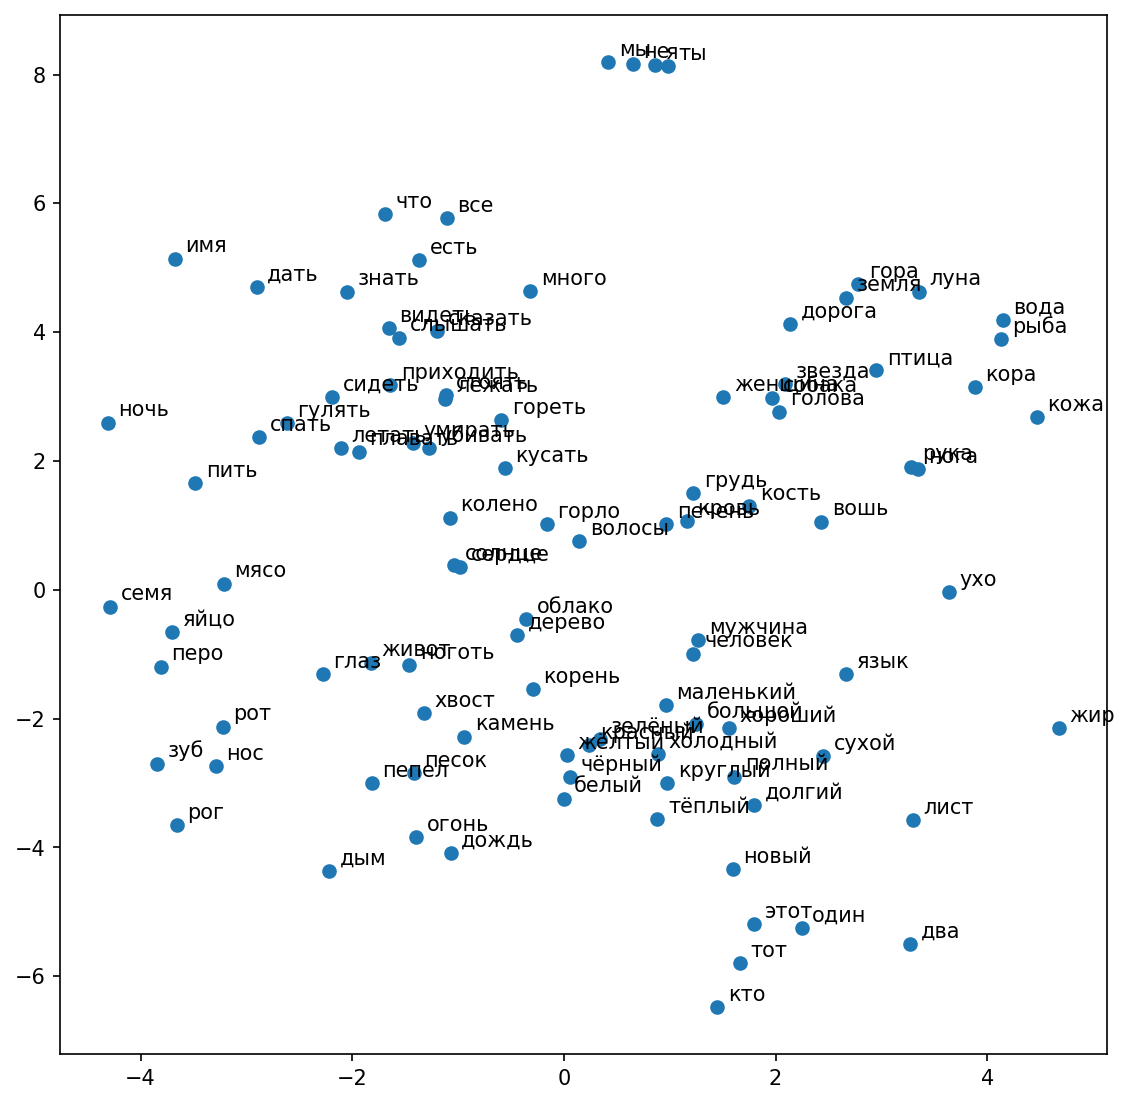

In [18]:
plt.figure(figsize=(9, 9), dpi=150)
plt.scatter(X[:, 0], X[:, 1]);

for (i,txt) in enumerate(swadesh_words):
    plt.annotate(txt, (X[i, 0] + 0.1, X[i, 1] + 0.1))

In [19]:
del m

### 2. Обучаем собственную модель

In [5]:
import nltk
import tqdm.notebook
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

Конвертация текста в токены

In [6]:
word2token = {'<UNK>': 0}
token2word = {0: '<UNK>'}
tokens = []
for s in tqdm.notebook.tqdm(nltk.sent_tokenize(text, language='russian')):
    for w in nltk.word_tokenize(s, language='russian'):
        if w not in word2token:
            i = len(word2token)
            word2token[w] = i
            token2word[i] = w
        tokens.append(word2token[w])
tokens = np.array(tokens)
print('Number of words in vocabulary: ', len(word2token))

  0%|          | 0/7395 [00:00<?, ?it/s]

Number of words in vocabulary:  14645


In [7]:
# import intel_extension_for_pytorch as ipex

In [8]:
len(tokens)

78182

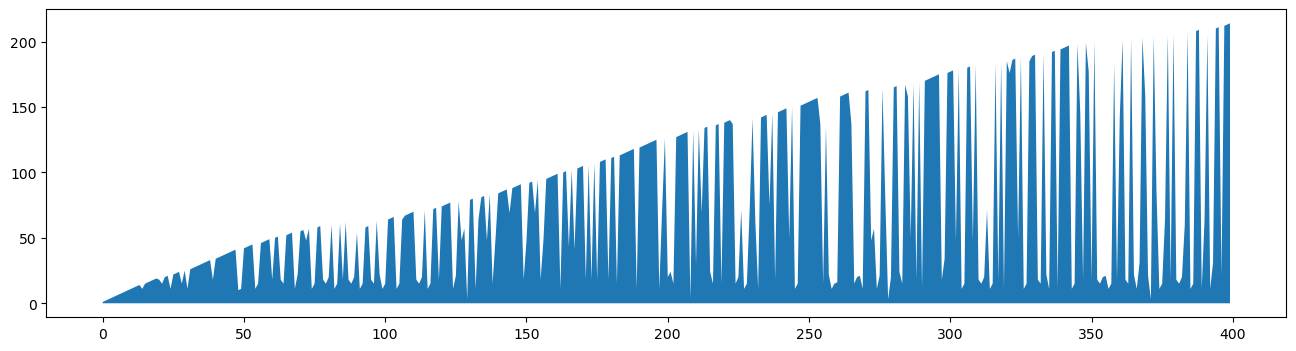

In [39]:
plt.figure(figsize=(16,4))
plt.fill_between(np.arange(400), tokens[0:400]);


Будем обучать CBOW модель

In [9]:
CONTEXT_LEN = 5
W = CONTEXT_LEN // 2

N_WORDS = len(word2token)

хешируем кортежи.

In [10]:
ctx2dist = {}    # map from tuples to word counters
offsets = np.array([x for x in range(-W, W+1) if x != 0])
for i in tqdm.notebook.tqdm(range(W, len(tokens)-W)):
    context = tokens[offsets + i]    # <- broadcasting
    w = tokens[i]
    context = tuple(context)     # tuple is hashable
    if context not in ctx2dist:
        ctx2dist[context] = np.zeros(N_WORDS, dtype=np.uint8)        
    cnt = ctx2dist[context][w]
    # note overflow protection
    if cnt >= 255:
        # надо избежать переполнения - у нас всего лишь байт, отмасштабируем все значения
        ctx2dist[context] //= 2
    ctx2dist[context][w] += 1

  0%|          | 0/78178 [00:00<?, ?it/s]

In [14]:
np.sum(ctx2dist[context])

1

In [9]:
len(ctx2dist), len(tokens)

(74166, 78182)

Теперь преобразуем словарь в тензоры.

В contexts будут коды токенов.

В targets будут распределения слов для соответствующих контекстов.

In [24]:
contexts = torch.zeros((len(ctx2dist), 2*W), dtype=torch.int32)

# тут хорошо бы подошли torch.sparse тензоры, но они в бете
targets = torch.zeros(len(ctx2dist), N_WORDS, dtype=torch.float32)

assert contexts.shape[0] == targets.shape[0]

j = 0
for c, d in ctx2dist.items():
    contexts[j, :] = torch.Tensor(c)    
    targets[j, :] = torch.Tensor(d)
    j += 1    

In [25]:
targets.sum()

tensor(78178.)

In [31]:
del ctx2dist

счетчики могут быть больше 1, надо их отмасштабировать.

In [26]:
(targets.sum(axis=1) > 1.001).sum()

tensor(1470)

In [29]:
for i in tqdm.notebook.tqdm(range(targets.shape[0])):    
    targets[i] = F.softmax(targets[i])    

  0%|          | 0/74166 [00:00<?, ?it/s]

/tmp/ipykernel_937065/3114614179.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  targets[i] = F.softmax(targets[i])


In [30]:
(targets.sum(axis=1) > 1.0001).sum()

tensor(0)

In [71]:
class CBOWDataset(Dataset):
    def __init__(self, contexts, targets):
        super().__init__()
        self._contexts = contexts
        self._targets = targets
        
    def __len__(self):
        return len(self._targets)
    
    def __getitem__(self, idx):
        return self._contexts[idx], self._targets[idx]
    
dataset = CBOWDataset(contexts[0:4000], targets[0:4000])

train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [81]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.DIM = 64
        self.embed = nn.Embedding(N_WORDS, self.DIM)
        self.expand = nn.Linear(self.DIM * 2 * W, N_WORDS, bias=False)
        
    def forward(self, context_tokens):
        hidden = self.embed(context_tokens)                            
        hidden = torch.flatten(hidden)
        out = self.expand(hidden)  
        return out

model = Model()
    
loss_fn = nn.CrossEntropyLoss()   

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    
EPOCHS = 256
loss_history = []
for epoch in tqdm.notebook.tqdm(range(EPOCHS)):    
    # train
    model.train()
    
    for batch, targets in train_dataloader:            
        for i in range(len(batch)):                                                         
            y_out = model.forward(batch[i])
            
            loss = loss_fn(y_out, targets[i])                  
            
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    # test
    model.eval()
    total_loss = 0.0
    k = 0
    with torch.no_grad():
        for batch, targets in test_dataloader:
            for i in range(len(batch)):                                                            
                y_out = model.forward(batch[i])                        
                loss = loss_fn(y_out, targets[i])                                                
                total_loss += loss.item()
                k += 1            
    total_loss /= k
    loss_history.append(total_loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch:3d}, Loss: {total_loss:.3f}')

  0%|          | 0/256 [00:00<?, ?it/s]

Epoch   0, Loss: 9.762
Epoch  10, Loss: 9.744
Epoch  20, Loss: 9.723
Epoch  30, Loss: 9.704
Epoch  40, Loss: 9.687
Epoch  50, Loss: 9.676
Epoch  60, Loss: 9.666
Epoch  70, Loss: 9.656
Epoch  80, Loss: 9.648
Epoch  90, Loss: 9.642
Epoch 100, Loss: 9.638
Epoch 110, Loss: 9.634
Epoch 120, Loss: 9.629
Epoch 130, Loss: 9.626
Epoch 140, Loss: 9.623
Epoch 150, Loss: 9.621
Epoch 160, Loss: 9.618
Epoch 170, Loss: 9.616
Epoch 180, Loss: 9.614
Epoch 190, Loss: 9.613
Epoch 200, Loss: 9.612
Epoch 210, Loss: 9.611
Epoch 220, Loss: 9.609
Epoch 230, Loss: 9.607
Epoch 240, Loss: 9.607
Epoch 250, Loss: 9.606


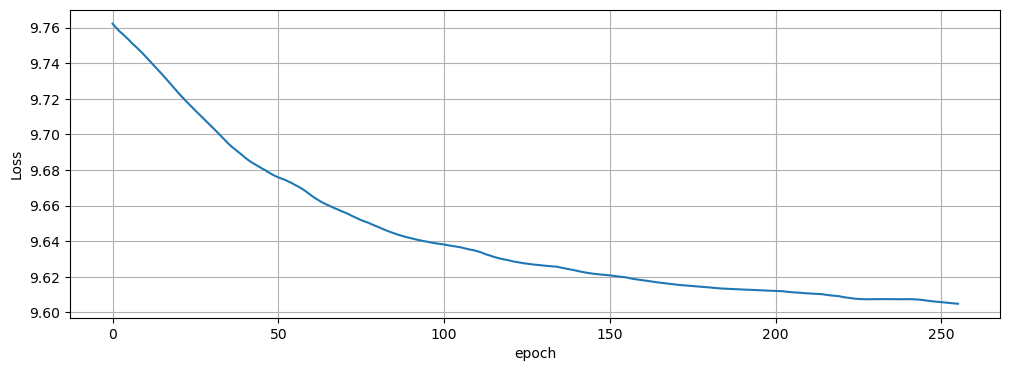

In [82]:
plt.figure(figsize=(12,4))
plt.plot(loss_history);
plt.ylabel('Loss')
plt.xlabel('epoch');
plt.grid(True);

In [68]:
%%time
with torch.no_grad():
    embeddings = model.embed(torch.tensor(np.arange(N_WORDS)))    
    X = TSNE(n_jobs=-1, verbose=1).fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14645 samples in 0.001s...
[t-SNE] Computed neighbors for 14645 samples in 0.246s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14645
[t-SNE] Computed conditional probabilities for sample 2000 / 14645
[t-SNE] Computed conditional probabilities for sample 3000 / 14645
[t-SNE] Computed conditional probabilities for sample 4000 / 14645
[t-SNE] Computed conditional probabilities for sample 5000 / 14645
[t-SNE] Computed conditional probabilities for sample 6000 / 14645
[t-SNE] Computed conditional probabilities for sample 7000 / 14645
[t-SNE] Computed conditional probabilities for sample 8000 / 14645
[t-SNE] Computed conditional probabilities for sample 9000 / 14645
[t-SNE] Computed conditional probabilities for sample 10000 / 14645
[t-SNE] Computed conditional probabilities for sample 11000 / 14645
[t-SNE] Computed conditional probabilities for sample 12000 / 14645
[t-SNE] Computed conditional probabilities for sam

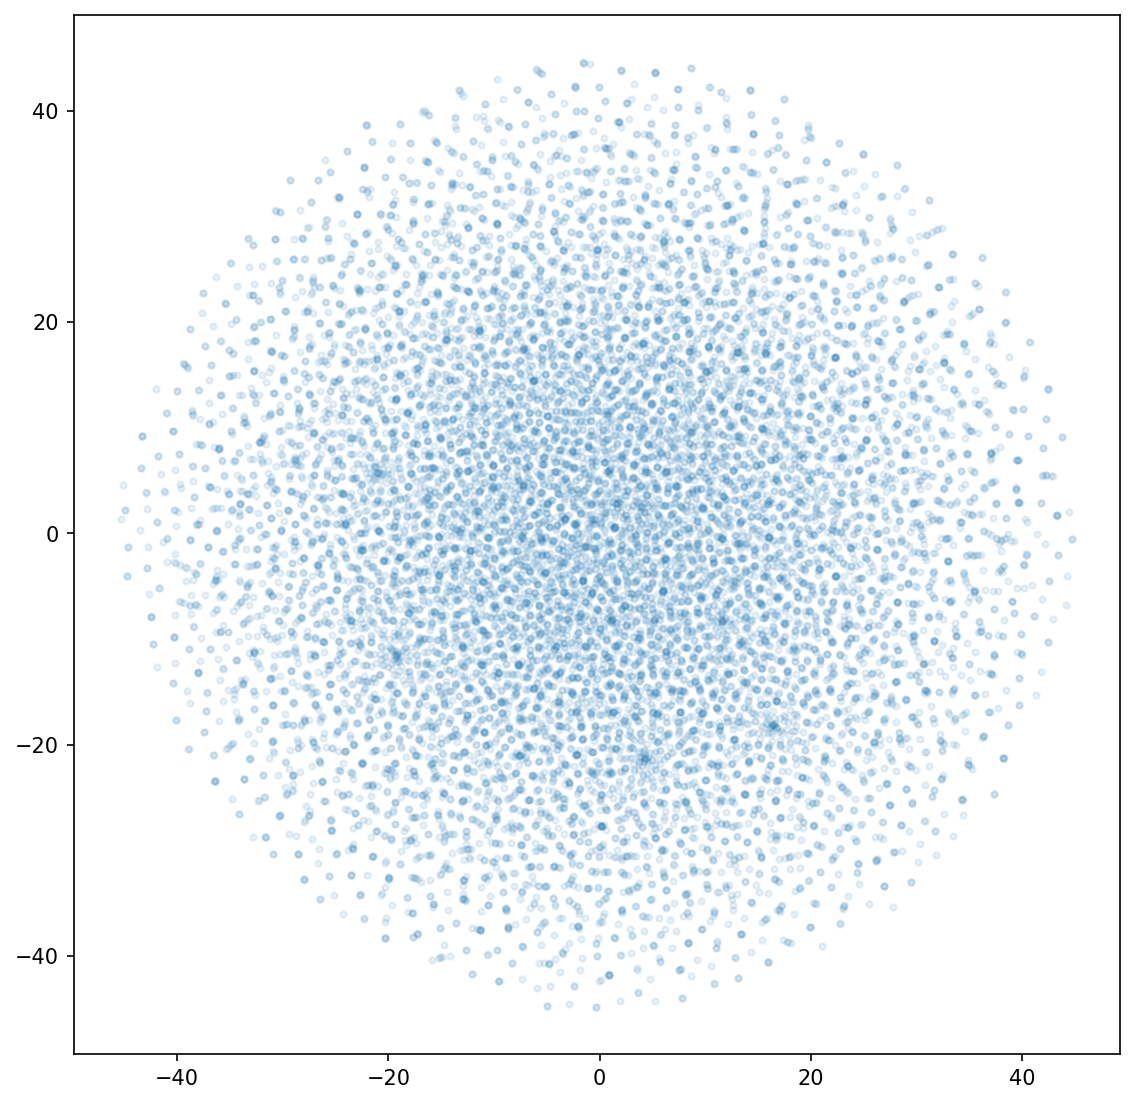

In [70]:
plt.figure(figsize=(9, 9), dpi=150)
plt.scatter(X[:, 0], X[:, 1], alpha=0.1, marker='.');